<a href="https://colab.research.google.com/github/baroodb/code/blob/main/videos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import pathlib
import tensorflow as tf
import fnmatch
import re
import sys

In [2]:
old_path = "clone/data"
classes = ['football', 'tennis', 'weight_lifting']
BATCH_SIZE = 32
EPOCHS = 10

In [3]:
!git clone https://github.com/jurjsorinliviu/Sports-Type-Classifier.git clone

Cloning into 'clone'...
remote: Enumerating objects: 14521, done.
remote: Total 14521 (delta 0), reused 0 (delta 0), pack-reused 14521
Receiving objects: 100% (14521/14521), 592.88 MiB | 37.42 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (14619/14619), done.


In [4]:
def copy_needed_folders(path, list_folders):
  
  for element in os.listdir(path):
    if os.path.isdir(os.path.join(path, element)) and element in list_folders:
      print(f'INFO: Printing the folder {element}')
      shutil.copytree(os.path.join(path, element), os.path.join('dataset', element))

def clean_path(path):
  files = []
  for root, dirnames, filenames in os.walk(path):
    for f in filenames:
      files.append(os.path.join(root, f))

  # to make it easy i will run a second for loop 
  for filename in files:
    if (not filename.endswith('.jpg')) and (not filename.endswith('.png')) \
                and (not filename.endswith('.JPG'))  and (not filename.endswith('.PNG')) \
                and (not filename.endswith('.jpeg')):
      print(filename)
  return files

In [5]:
def imageFile(str):
 
    # Regex to check valid image file extension.
    regex = "([^\\s]+(\\.(?i)(jpe?g|png|gif|bmp))$)"
     
    # Compile the ReGex
    p = re.compile(regex)
 
    # If the string is empty
    # return false
    if (str == None):
        return False
 
    # Return if the string
    # matched the ReGex
    if(re.search(p, str)):
        return True
    else:
        return False

In [6]:

def clean_path2(path):
  files = []
  for root, dirnames, filenames in os.walk(path):
    for f in filenames:
      files.append(os.path.join(root, f))

  # to make it easy i will run a second for loop 
  for filename in files:
    if not imageFile(filename):
      print(f"INFO: Deleting the file {filename}")
      os.unlink(filename)
  return files

In [7]:
# copying the necessary directories
copy_needed_folders(old_path, classes)

INFO: Printing the folder tennis
INFO: Printing the folder football
INFO: Printing the folder weight_lifting


In [9]:
t = clean_path2('dataset')
len(t)

2073

In [10]:
# lets build the dataset 
IMG_SIZE = (224, 224)
SEED = 123
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('dataset', image_size=IMG_SIZE, validation_split=0.2, subset='training', seed=SEED)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory('dataset', image_size=IMG_SIZE, validation_split=0.2, subset='validation', seed=SEED)

Found 2073 files belonging to 3 classes.
Using 1659 files for training.
Found 2073 files belonging to 3 classes.
Using 414 files for validation.


In [11]:
#classes
class_names = train_dataset.class_names
class_names

['football', 'tennis', 'weight_lifting']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


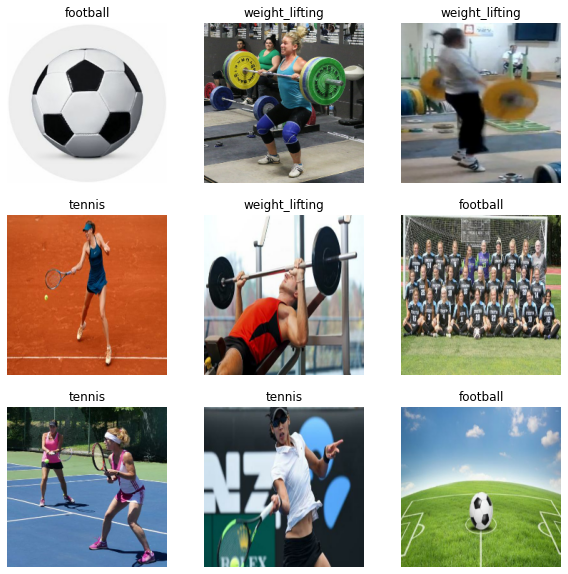

In [12]:
# lets plot some images to see what is going on
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(9):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [13]:
# here we build data_augmentation 
aug_layer = tf.keras.Sequential(
    [tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)]
)

In [14]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)

In [15]:
def cache_ds(dataset, training=True):
  dataset = dataset.cache()
  if training:
    dataset = dataset.shuffle(buffer_size=3000)
  
  #dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

In [16]:
train_ds = train_dataset.map(lambda image, label: (rescale(image), label))
val_ds = val_dataset.map(lambda image, label: (rescale(image), label))

In [17]:
train_ds = cache_ds(train_ds)
val_ds = cache_ds(val_ds, training=False)

In [ ]:
next(iter(train_ds))

In [46]:
# load the pretrained model 
base = tf.keras.applications.ResNet50(include_top=False)

In [47]:
base.output

<KerasTensor: shape=(None, None, None, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [48]:
for layer in base.layers:
  layer.trainable = False

In [45]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = aug_layer(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names))(x)

In [50]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = aug_layer(inputs)
x = base(x, training=False)
x = tf.keras.layers.AveragePooling2D((7, 7))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(class_names))(x)

In [55]:
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, decay=1e-2/10), 
              metrics=['accuracy'])

In [52]:
model.evaluate(val_ds)

13/13 [==============================] - 5s 218ms/step - loss: 1.4105 - accuracy: 0.2633


[1.4104793071746826, 0.2632850110530853]

In [56]:
model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=50)

Epoch 1/50
52/52 [==============================] - 23s 316ms/step - loss: 1.1505 - accuracy: 0.3478 - val_loss: 1.0942 - val_accuracy: 0.3841
Epoch 2/50
52/52 [==============================] - 15s 294ms/step - loss: 1.0944 - accuracy: 0.3779 - val_loss: 1.0857 - val_accuracy: 0.3865
Epoch 3/50
52/52 [==============================] - 15s 293ms/step - loss: 1.0959 - accuracy: 0.3502 - val_loss: 1.0906 - val_accuracy: 0.3865
Epoch 4/50
52/52 [==============================] - 15s 293ms/step - loss: 1.0936 - accuracy: 0.3647 - val_loss: 1.0867 - val_accuracy: 0.3865
Epoch 5/50
52/52 [==============================] - 15s 293ms/step - loss: 1.0936 - accuracy: 0.3550 - val_loss: 1.0863 - val_accuracy: 0.3865
Epoch 6/50
 4/52 [=>............................] - ETA: 11s - loss: 1.1119 - accuracy: 0.3659

KeyboardInterrupt: ignored